<h1>
Introduction to SuperNeuroABM
</h1>
<p>
    SuperNeuroABM is a pure-Python Agent-Based Modeling (ABM) software for training spiking neural networks (SNN). ABM is a popular modeling technique for simulating complex adaptive systems. SuperNeuroABM takes a complex adaptive systems perspective to simulating SNNs by models Neurons as autonomous agents. This approach has proven to be advantagous by allowing for easier parallelism and stronger scaling through GPU computing and allowing the AI practioner to specify multiple breeds of neuron and synapse mechanisms within a single SNN for heterogenous simulations.
    SuperNeuroABM provides both CPU and GPU support. In GPU mode, Neuron properties are convereted to agent data tensors that are distributed across GPU threads using Numba. Each agent is processed by a single GPU thread, which executes the neuronal and synaptic step functions. 
</p>
<div>
    <img src="img/systemoverview.png" width="1000" alt="System Overview" />
</div>

We will apply input spikes to neuron 0, and observe spikes from all the neurons in the network.

In [1]:
!pip uninstall -y superneuroabm
!pip install git+https://github.com/ornl/superneuroabm@dev
#!pip install matplotlib

Found existing installation: SuperNeuroABM 0.1.0
Uninstalling SuperNeuroABM-0.1.0:
  Successfully uninstalled SuperNeuroABM-0.1.0
  Cloning https://github.com/ornl/superneuroabm (to revision dev) to /tmp/pip-req-build-9fi50kon
  Running command git clone --filter=blob:none --quiet https://github.com/ornl/superneuroabm /tmp/pip-req-build-9fi50kon
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  branch 'dev' set up to track 'origin/dev'.
  Resolved https://github.com/ornl/superneuroabm to commit 7fce4106f44a7e0d782687da9876ca6a373e8375
  Preparing metadata (setup.py) ... done
  Created wheel for SuperNeuroABM: filename=SuperNeuroABM-0.1.0-py3-none-any.whl size=12268 sha256=cc95e8a9227e0f637c7a307c5115ab5df4fac5d8433c91260568b5ff19074574
  Stored in directory: /tmp/pip-ephem-wheel-cache-oelvn1y8/wheels/03/22/e7/f78ff431562b280605b2af653bdb028f38af39b5ce006ef8b2
Successfully built SuperNeuroABM


In [2]:
from superneuroabm.model import NeuromorphicModel

<div>
    <img src="img/neuralnetworkarchitecture.png" width="500" alt="SNN architecture" />
</div>

In [3]:
# Configure the simulation parameters:
sim_time = 100
neuron_threshold = 1.0
neuron_reset = -1.0
neuron_refractory = 1.0


snn_model = NeuromorphicModel(use_cuda=False)

neurons = {"input": None, "hidden": None, "output": None}

for neuron_name in neurons.keys():
    neurons[neuron_name] = snn_model.create_neuron(
        threshold=neuron_threshold,
        reset_state=neuron_reset,
        refractory_period=neuron_refractory,
    )

print(neurons)

{'input': 0, 'hidden': 1, 'output': 2}


In [4]:
# Create Synpase:
snn_model.create_synapse(neurons["input"], neurons["hidden"], 
            synaptic_delay = 2,
            weight = 4,
        )

snn_model.create_synapse(neurons["hidden"], neurons["output"],    # TODO: Chathika can you check why the neuron_h spikes are not available at end of simulation
            synaptic_delay = 3,                  
            weight = 2,
        )

In [5]:
# Apply Spikes:
snn_model.spike(neurons["input"], 0, 2)    # (node_id, spike_time, spike_value)
snn_model.spike(neurons["input"], 10, 4)

# Add the input spikes to the common list:
network_spikes = []
network_spikes.append([0, 10])

# Setup the model
snn_model.setup()

#Begin simulation:
snn_model.simulate(ticks=sim_time, update_data_ticks=1)

Simulation Progress: 100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2.88kTick/s]


In [6]:
# Monitor the output spikes from all neurons:
in_spikes = snn_model.get_spikes(neurons["input"])
h_spikes = snn_model.get_spikes(neurons["hidden"])
out_spikes = snn_model.get_spikes(neurons["output"])

print(neurons["input"], neurons["hidden"], neurons["output"])

0 1 2


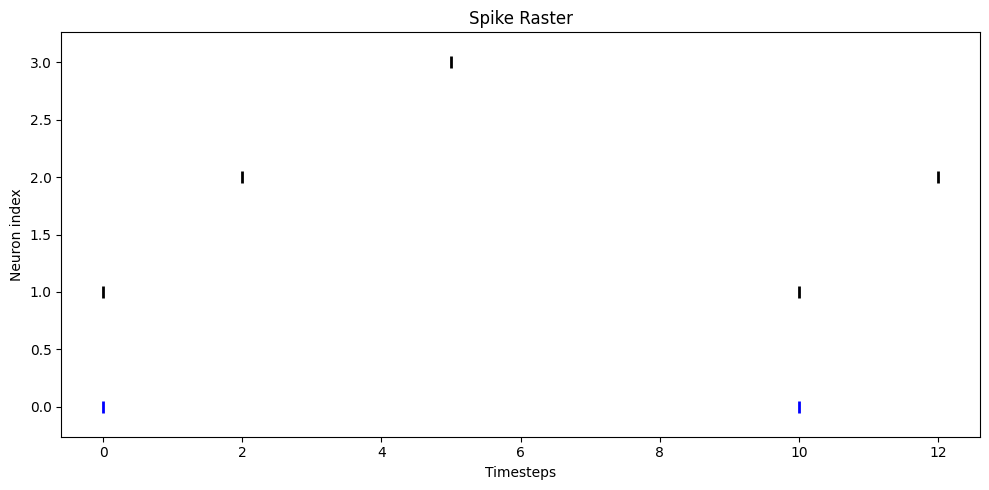

In [7]:
# Plot the spike raster:
#from superneuroabm.core.agent import *

import matplotlib.pyplot as plt

for neuron_id in neurons.values():
    network_spikes.append(snn_model.get_spikes(neuron_id))

colors1 = ['b', 'k', 'k', 'k']  #Input spikes in blue and network spikes in black
fig, axs = plt.subplots(1,1,figsize=(10,5))
axs.eventplot(network_spikes,colors=colors1,lineoffsets=1,linelengths=0.1,linewidths=2.0)
plt.title('Spike Raster')
plt.xlabel('Timesteps')
plt.ylabel('Neuron index')
plt.tight_layout()
#plt.gca().invert_yaxis()

# Agent-Based Modeling and Heterogenous Mechanisms 

Next, we will modify the network architecture to use two neuron mechanisms instead of one. 
SuperNeuroABM lets us do this by defining breeds. A dictionary may be passed upon creation of Neuromorphic model whose keys are names of Neuron breeds and values are lists of step functions that the respective breed should execute. Note the step function list should be provided in order of execution. 

The architecture used is displayed in the image below
<div>
    <img src="img/neuralnetworkarchitectureSTDP.png" width="600" alt="SNN architecture with STDP" />
</div>

First, we need to describe our breeds in a dictionary and use it to initialize a new model. We can use predefined step functions that SuperNeuroABM provides for this purpose

In [8]:
from superneuroabm.neuron import neuron_step_func, synapse_step_func, synapse_with_stdp_step_func

neuron_breed_info = {"LIF": [neuron_step_func, synapse_step_func], "LIFForwardSTDP": [neuron_step_func, synapse_with_stdp_step_func]}
multibreed_model = NeuromorphicModel(use_cuda=False, neuron_breed_info=neuron_breed_info)

Next let's create the three neurons. However, this time we will use the `breed` parameter to specify which breed the Neuron will belong to.

In [9]:
 # Create neurons
input_0 = multibreed_model.create_neuron(
    breed="LIF", threshold=0.0
)
input_1 = multibreed_model.create_neuron(breed="LIFForwardSTDP", threshold=0.0)
output_2 = multibreed_model.create_neuron(breed="LIF", threshold=1.0)

# Create synapses
multibreed_model.create_synapse(
    pre_neuron_id=input_0, post_neuron_id=output_2, weight=4, synaptic_delay = 5,
)
multibreed_model.create_synapse(
    pre_neuron_id=input_1, post_neuron_id=output_2, weight=2, synaptic_delay = 3,
)

Next let's add spikes to the model and simulate

In [10]:
spikes = {
    1: [
        (input_0, 0),
        (input_1, 0),
    ],  # Input: (0, 0); Expected output: No spike
    3: [
        (input_0, 0),
        (input_1, 1),
    ],  # Input: (0, 1); Expected output: Spike at time 4
    5: [
        (input_0, 1),
        (input_1, 0),
    ],  # Input: (1, 0); Expected output: Spike at time 6
    7: [
        (input_0, 1),
        (input_1, 1),
    ],  # Input: (1, 1); Expected output: Spike at time 8
}
expected_times = [8]
for time in spikes:
    for neuron, value in spikes[time]:
        multibreed_model.spike(neuron_id=neuron, tick=time, value=value)

# Setup and simulate
multibreed_model.setup()

In [11]:
multibreed_model.simulate(ticks=sim_time, update_data_ticks=1)

Simulation Progress: 100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2.94kTick/s]


In [15]:
w_input_0_output = multibreed_model.get_synapse_weight(0,2)
w_input_1_output = multibreed_model.get_synapse_weight(1,2)

print(f"Weight of synapse input 0 -> output {w_input_0_output}")
print(f"Weight of synapse input 1 -> output {w_input_1_output}")

Weight of synapse input 0 -> output 4.0
Weight of synapse input 1 -> output 450.97286867893445


Writing your own step functions is out of scope for this tutorial. Examples of what these step functions should look like are provided here: https://github.com/ORNL/superneuroabm/blob/main/superneuroabm/neuron.py